# Zeez 😴

_sleep improvement using wearables and n-of-1 experiments_

[Project Homepage](http://people.ischool.berkeley.edu/~marcelo.queiroz/Zeez/ "Zeez Project Homepage") 

## Explore Notebook

This notebook showcases an  in the following order:
1. Data ingestion
2. User data
3. Sleep data
4. Activity data
5. Experiments data
6. Conclusion and useful links

## Housekeeping

In [1]:
# EDA general imports imports:
import json
import numpy as np
import pandas as pd 
import os
from os import mkdir
from os import chdir
from zipfile import ZipFile
import datetime as dt
import time
from pandas.io.json import json_normalize

# imports for plotting charts and graphics:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# imports for 
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


Bad key "changing the colors used" on line 1 in
/Users/marceloqueiroz/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/marcelo_style_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/Users/marceloqueiroz/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Ingestion
Let's load the dataset created previously in the ETL notebooks. You can find how that was created on the links in the navigation bar of this page.

In [2]:
# veryfying existing datasets in local disk:
current_dir = os.getcwd()
root_dir = current_dir.split('/project')[0]
data_folder_path = root_dir + \
                   '/project/capstone_fall_2019/Step_2_Data pipeline development/Step_2.1_Data ingestion and EDA/data_ingestion/'

# if there is a file from the last 10 days, use the most recent.
for i in range(10):
    valid_path = '{}'.format((dt.date.today() - dt.timedelta(days=i)).strftime('%d%m%Y')) + '/gold_dataset.zip'
    if os.path.isfile(data_folder_path + valid_path):
        most_recent_ds_path = data_folder_path + valid_path
        print('loading file from {}'.format(dt.date.today() - dt.timedelta(days=i)))
        
        zipObj = ZipFile(most_recent_ds_path)
        break
    else:
        print('No file from {} on local directories.'.format((dt.date.today() - dt.timedelta(days=i)).strftime('%m/%d/%Y')))
        
# print available files:
zipObj.filelist    

No file from 12/08/2019 on local directories.
No file from 12/07/2019 on local directories.
No file from 12/06/2019 on local directories.
loading file from 2019-12-05


[<ZipInfo filename='users_data.csv' filemode='-rw-r--r--' file_size=9562>,
 <ZipInfo filename='sleep_data.csv' filemode='-rw-r--r--' file_size=48139292>,
 <ZipInfo filename='readiness_data.csv' filemode='-rw-r--r--' file_size=2443200>,
 <ZipInfo filename='activity_data.csv' filemode='-rw-r--r--' file_size=237720835>,
 <ZipInfo filename='gold.csv' filemode='-rw-r--r--' file_size=286634079>,
 <ZipInfo filename='experiments.csv' filemode='-rw-r--r--' file_size=51210>]

In [3]:
# Loading individual datasets for exploration:
user_df = pd.read_csv(zipObj.open('users_data.csv'))
sleep_df = pd.read_csv(zipObj.open('sleep_data.csv'))
readiness_df = pd.read_csv(zipObj.open('readiness_data.csv'))
activity_df = pd.read_csv(zipObj.open('activity_data.csv'))
experiments_df = pd.read_csv(zipObj.open('experiments.csv'))

# Finally loading the full dataset and closing the zipfile:
df = pd.read_csv(zipObj.open('gold.csv'), index_col='user_date')
zipObj.close()

As we've seen, the dataset zip file contains separate files for sleep, readiness, activity and experiments data. All features in those datasets, combined with user attributes like gender, weight, and height, will form the `gold_dataset`, or simply `df` here, where we will pick the features to build our models. Also important to note that all these features are detailed on [data_dictionary.md](https://github.com/ShirazChakraverty/zeez_mvp/blob/master/data_dictionary.md) file in our [Github Repo](https://github.com/ShirazChakraverty/zeez_mvp/). 

For now, Let's know the features available on each dataset better:

## User Features:

For anonymization purposes, we dropped the `email` feature from all users in this notebook. However, emails were kept in the original application as a form to contact users directly with their recommendations. The available features of the users are in the form:


In [4]:
user_df.drop(['email'], axis=1, inplace=True)
print('Active user count:', user_df.shape[0])
user_df.head()

Active user count: 100


,age,height,is_male,signupDate,user_id,weight
0,NaN,NaN,NaN,2019-07-19 20:38:48.490,KYBIXCSH6KZL4ZUTBPNVTLYGYE4YVQ6W,NaN
1,25.0,193.0,1.0,2019-09-16 18:09:06.536,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ,67.5
2,NaN,NaN,NaN,2019-04-12 13:16:02.661,JEHBSVZW5BU6KIMXO2MDJHWVY7SZO5SX,NaN
3,23.0,178.0,1.0,2019-07-11 12:53:21.507,EFR5GF6DIOEH7IP7PUZOZMHQOWOIMCNE,66.4
4,NaN,NaN,NaN,2019-03-11 10:56:06.224,35MFM6FVESRUSFVVT42XZ4EESW2QDWO6,NaN


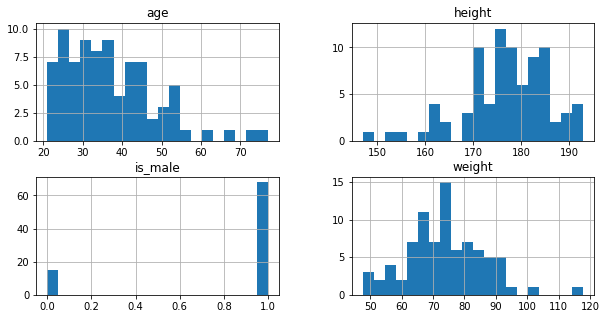

In [5]:
hist = user_df.hist(figsize=(10,5), bins=20)
plt.show()

We see that most of our users are man (~65%), in their 20's o 30's, and measuring 1.75 m (5"9') and weighting 75 kg (165 lb.). According to the [National Health Statistics Reports](https://www.cdc.gov/nchs/data/nhsr/nhsr122-508.pdf) of the CDC, the average American indeed has 5"9', but weights 197 lb., suggesting the our population tends to be in better shape and health conditions than the average population, a fair assumption for someone that buys a $ 250 device to improve overall health. 

There are several users that chose not to report their age, height, weight, and gender, therefore we will need to keep that in mind when picking algorithms that are less sensitive to missing data. Also is important to note that these are self-reported quantities that comes from Oura dataset, which we all know that are prone to be biased and/or outdated.

In order to verify if there are visible clusters within our users, we used [UMAP](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html) to reduce our dataset dimensions to a 2D visualization while accounting for non-linearities in the features’ relationships. Here, the features were filtered to contain only the numerical ones.

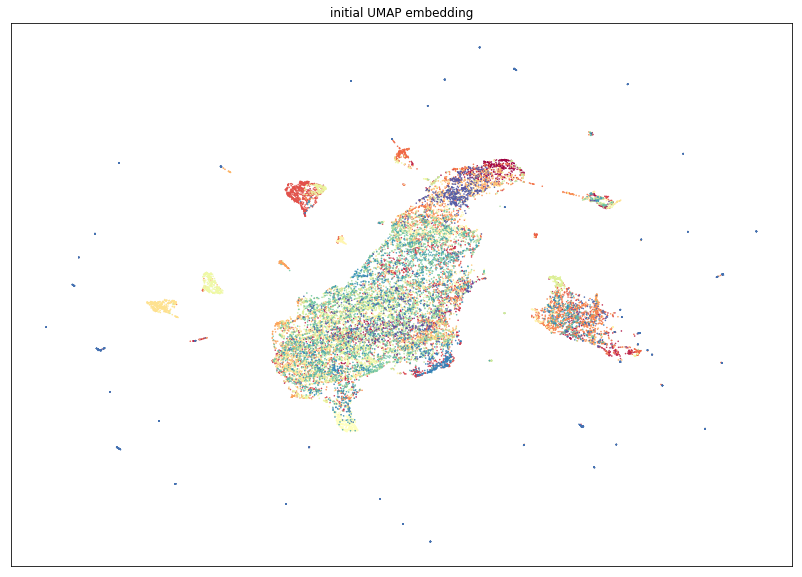

In [6]:
# Feature selection: using only numerical features
features_to_reduce = ['bedtime_end_dev+1','bedtime_end_dev+2','bedtime_end_dev+3','bedtime_end_dev-1','bedtime_end_dev-2',
                      'bedtime_end_dev-3','bedtime_start_delta','bedtime_start_dev+1','bedtime_start_dev+2','bedtime_start_dev+3',
                      'bedtime_start_dev-1','bedtime_start_dev-2','bedtime_start_dev-3','breath_average','duration_dev+1',
                      'duration_dev+2','duration_dev+3','duration_dev-1','duration_dev-2','duration_dev-3','hr_average',
                      'is_traveling','is_workday','light','rol_bedtime_end_delta_7d','rol_bedtime_start_delta_7d','rol_duration_7d',
                      'rol_onset_latency_7d','rol_sleep_score_7d','sleep_score','age','average_met','height','is_male',
                      'rol_activity_score_7d','rol_afterwake_exercise_min_7d','rol_beforesleep_exercise_min_7d','rol_cal_total_7d',
                      'rol_eve_exercise_min_7d','rol_high_7d','rol_inactive_7d','rol_medium_7d','rol_met_min_high_7d',
                      'rol_met_min_medium_7d','rol_met_min_medium_plus_7d','rol_non_wear_7d','rol_noon_exercise_min_7d',
                      'rol_score_move_every_hour_7d','rol_score_stay_active_7d','rol_steps_7d','weight']

# droping rows with NaNs and reseting the index to get the user_ids:
clean_df = df[features_to_reduce].dropna()
clean_df.reset_index(inplace=True)
usrid = clean_df['user_date'].str.split('|', n = 1, expand = True)
clean_df['user_id'] = usrid[0]

lb_make = LabelEncoder()
clean_df["user_code"] = lb_make.fit_transform(clean_df["user_id"])

users = clean_df['user_code']

clean_df.drop(['user_id', 'user_code','user_date'], axis=1, inplace=True)

reducer = umap.UMAP(n_neighbors=10, n_components=2)
embedding = reducer.fit_transform(clean_df)

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=users, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title('initial UMAP embedding')
plt.show()

In the chart above, different users have different colors, and as we've seen, users tend to group their `user_date`. However, at this initial point we were not able to identify more than two clear possible clusters, which reinforces our assumption that the current users are similar enough to use the independent `user_date` approach.

Finally, we wanted to see if there are visible differences on male and female users. For this, once again we can use UMAP.

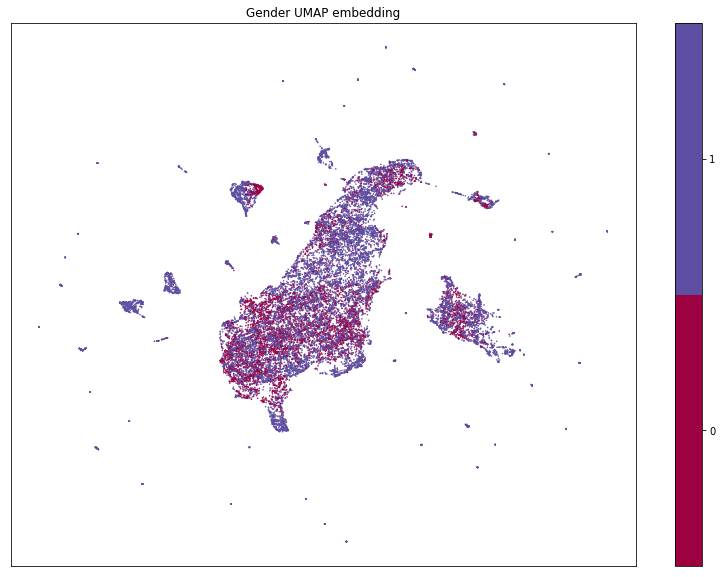

In [7]:
gender =  clean_df['is_male']
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=gender, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('Gender UMAP embedding')
plt.show()

We see that male (1) and female (0) users are mixed together with no distinguishable clusters, therefore at first stage of this work, we won't proceed with any unsupervised technique to group users by any kind of similarity.

This analysis show that there may be room to improve our models later, doing some tests with different similarity metrics and looking for ways to cluster our users in effective way. An well implemented unsupervised model added to our pipeline could enable new users to have more individualized recommendation after just a few `user_date`s as well as could open possibilities to explore semi-supervised models for our `sleep_score` predictions. 

## Sleep Features:

The original sleep dataset has features that are part of the `sleep_score` in known linear ways (per [Oura documentation]( https://cloud.ouraring.com/docs/sleep)), but also unknown linear relationships are present. In order to better understand how the available features connected to our target (`sleep_score`), we developed the following diagram:

![sleep features diagram](https://docs.google.com/drawings/d/e/2PACX-1vTl1Sb4qYO_JKAwSzlnbJFoHsm9Re4oN8U3DAVdeqg33chndBEx4wUCddXgHYThjzN3HAyXTwqUnWYp/pub?w=960&h=720)

The blue-shaded variables are directly related to `sleep_score` with the represented weights. The arrows represent possible causal relationships that were generated from our literature review on sleep science.

Finally, we created features that are meant to capture the routine of the users (like `average_bedtime_start_delta`, `is_traveling`, dummy `bedtime_end_deviation`, etc.).


In [8]:
sleep_df.head()

,user_date,avg_sleep_score_next_week,awake,awake_norm,bedtime_end,bedtime_end_delta,bedtime_end_dev+1,bedtime_end_dev+2,bedtime_end_dev+3,bedtime_end_dev-1,...,total,tz_delta,user_id,weekday_fri,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed
0,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-23,70.400000,2490,0.130503,2019-04-24T08:41:26+02:00,31286,0.0,0.0,0.0,0.0,...,16590,-0.0,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ,0.0,0.0,0.0,0.0,0,1.0,0.0
1,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-24,69.333333,4200,0.164706,2019-04-25T10:19:59+02:00,37199,0.0,0.0,0.0,0.0,...,21300,-0.0,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ,0.0,0.0,0.0,0.0,0,0.0,1.0
2,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-25,NaN,5610,0.166964,2019-04-26T12:29:47+02:00,44987,0.0,0.0,0.0,0.0,...,27990,-0.0,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ,0.0,0.0,0.0,0.0,1,0.0,0.0
3,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-28,NaN,4560,0.107801,2019-04-29T11:46:09+02:00,42369,0.0,0.0,0.0,0.0,...,37740,-0.0,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ,0.0,0.0,0.0,1.0,0,0.0,0.0
4,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-29,NaN,5970,0.165282,2019-04-30T10:53:29+02:00,39209,0.0,0.0,0.0,0.0,...,30150,-0.0,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ,0.0,1.0,0.0,0.0,0,0.0,0.0


In [9]:
sleep_df.shape

(28600, 96)

Here is important to point one of the main assumptions we used in this work: daily sleep scores are independent variables, therefore we are able to use a concatenation of `user_id` and `summary_date` to uniquely identify a record. This also assumes all users are similar enough to be treated as one (as already stated in User Data section).

To verify the independence assumption of `user_date` we can verify the plots and run an autocorrelation analysis:

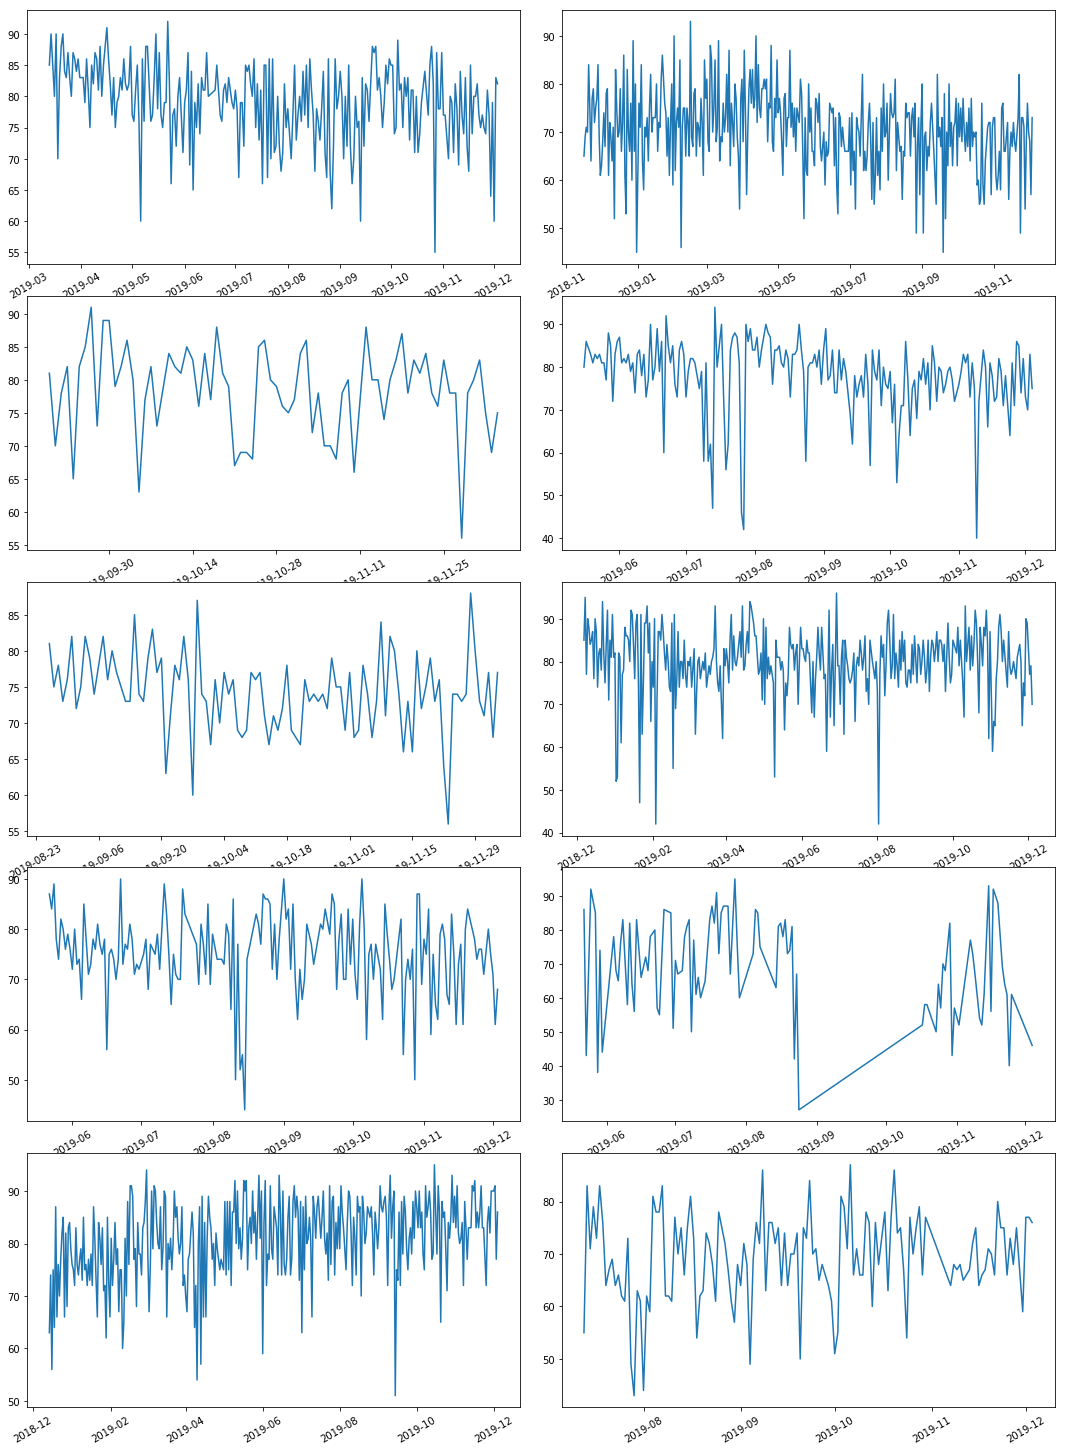

In [10]:
# plot 10 random user sleep score time series:
user_array = np.random.choice(sleep_df['user_id'].unique(), 10, replace=False)

fig, ax = plt.subplots(5,2,figsize=(15,20))
plt.tight_layout()

for count, user in enumerate(user_array):
    r = count//2
    if count%2 <1:
        c = 0
    else:
        c = 1
    user_plot = sleep_df[sleep_df['user_id'] == user]
    x = pd.to_datetime(user_plot['summary_date'])
    y = user_plot['sleep_score']
    
    ax[r,c].axes.xaxis_date
    plt.setp(ax[r,c].xaxis.get_majorticklabels(), rotation=30)
    ax[r,c].plot(x,y)
    
plt.show()

In [11]:
pd.to_datetime(sleep_df['summary_date']).min()

Timestamp('2017-03-11 00:00:00')

From the previous timeseries we see that different users have different amounts of data, with some starting as early as 2018 and some starting at October 2019 (in a matter of fact, the first `user_date` dates from march 2017). Also note we cannot see seasonality (at least not upfront), but let's take a look on an autocorrelation analysis:

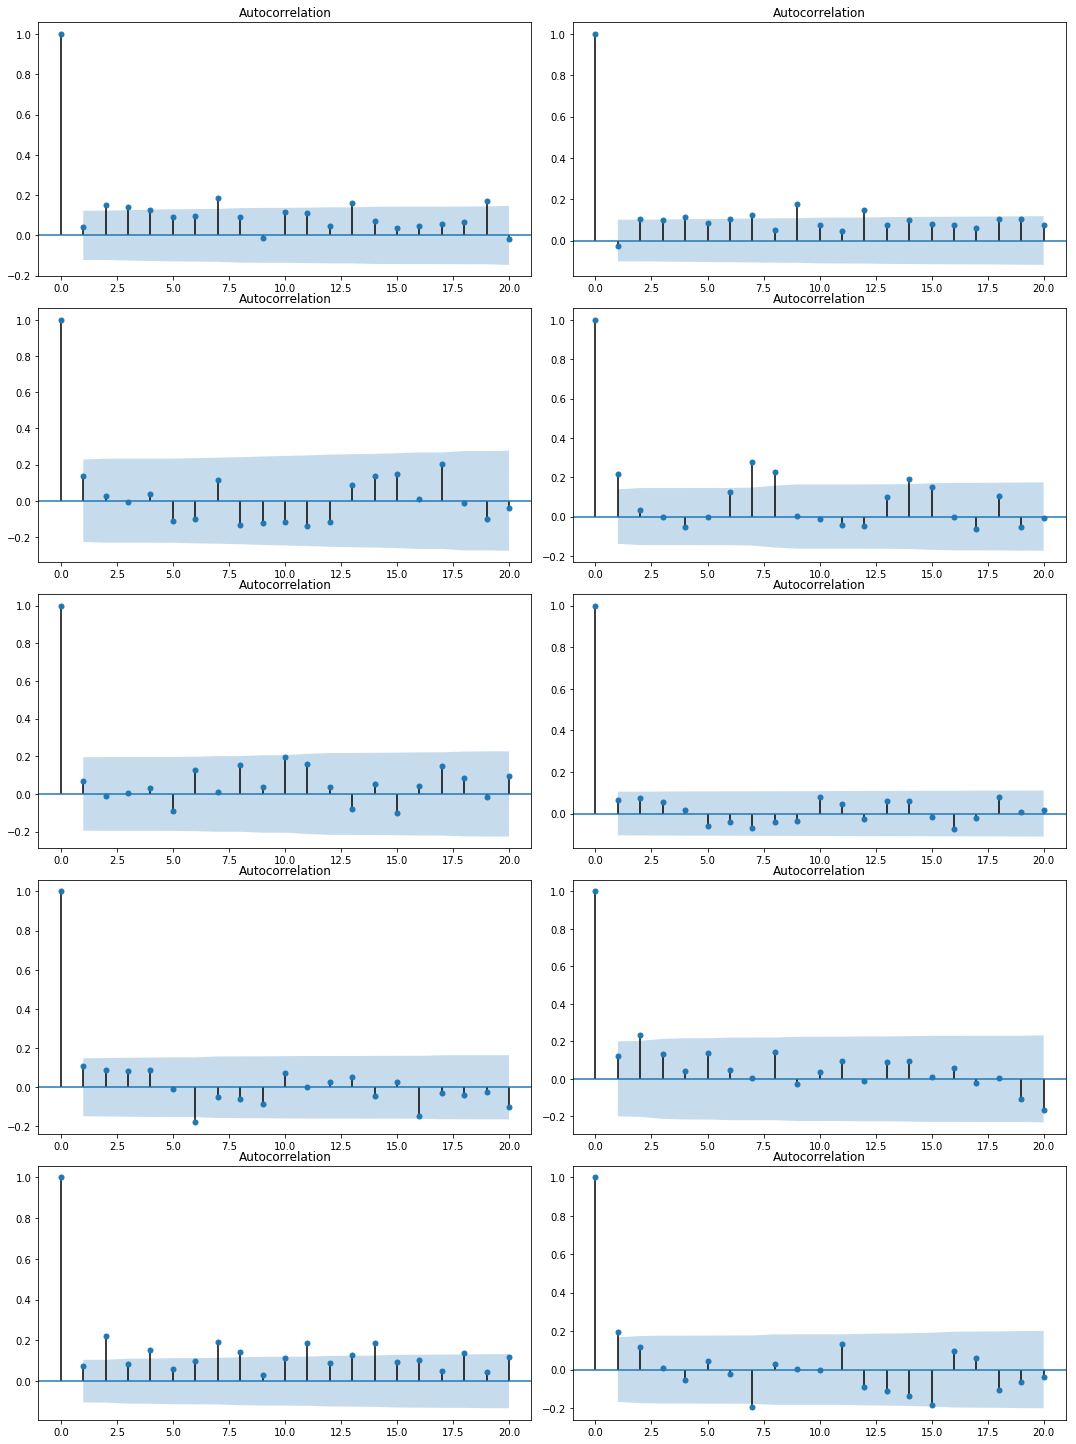

In [12]:
# use the same random user array to plot auto correlation analisys:
fig2, ax2 = plt.subplots(5,2,figsize=(15,20))
plt.tight_layout()

for count, user in enumerate(user_array):
    r = count//2
    if count%2 <1:
        c = 0
    else:
        c = 1
        
    user_plot = sleep_df[sleep_df['user_id'] == user]
    plot_acf(user_plot['sleep_score'], ax=ax2[r,c], lags=20)
    
plt.show()

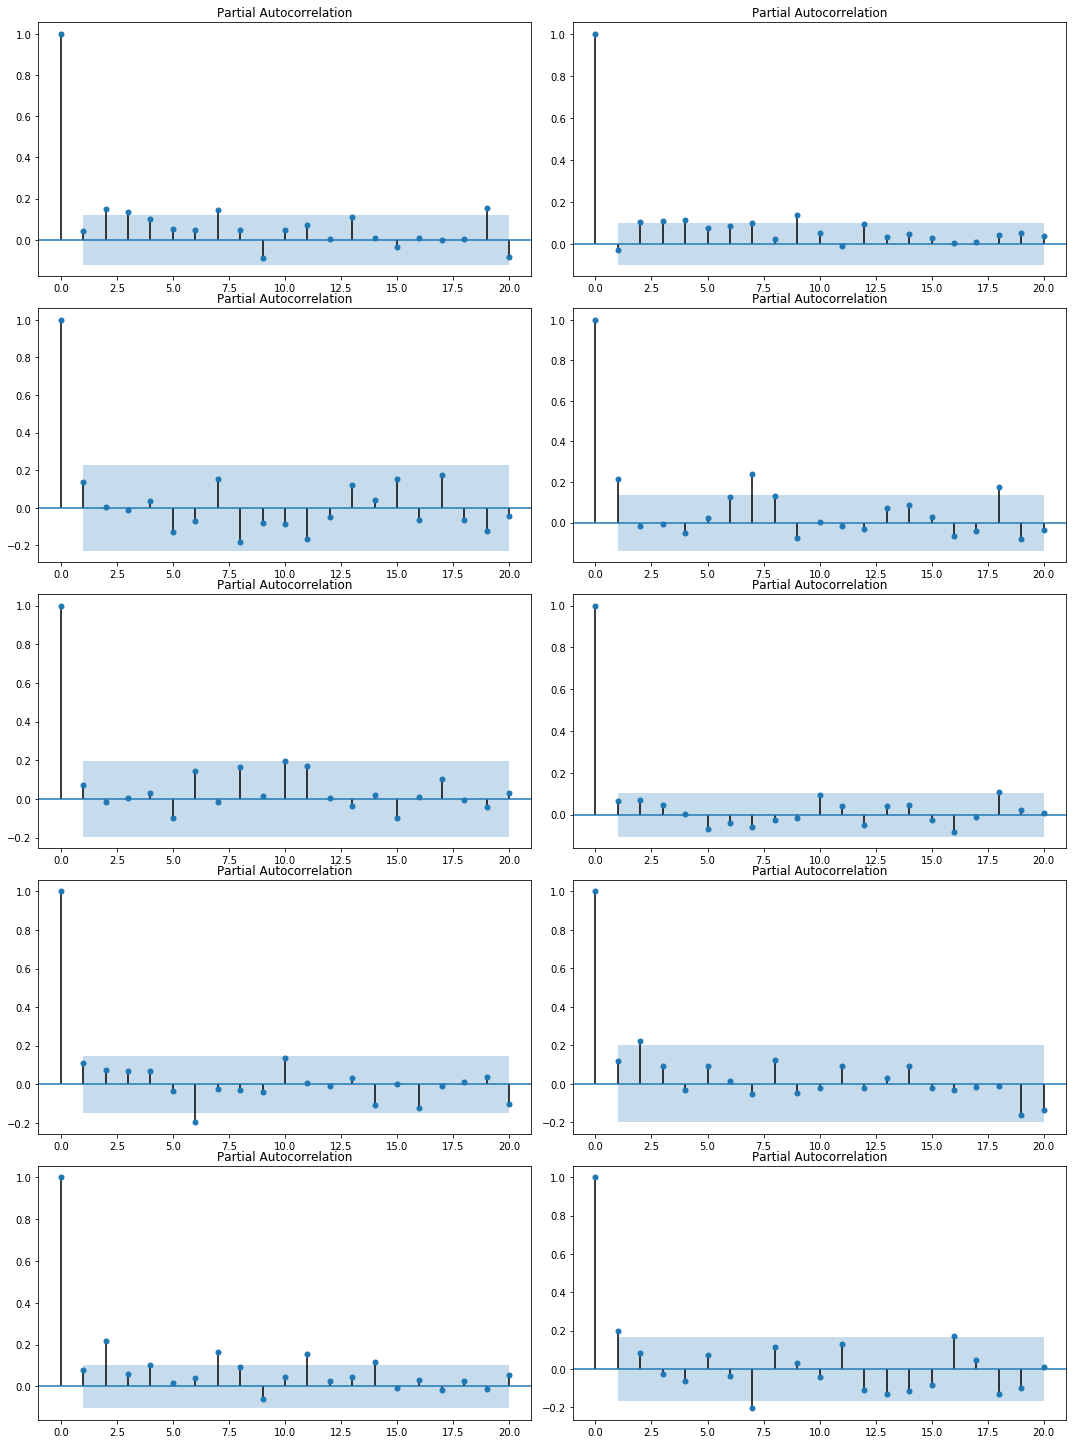

In [13]:
# use the same random array of users to run an partial autocorrelation analisys
fig3, ax3 = plt.subplots(5,2,figsize=(15,20))
plt.tight_layout()

for count, user in enumerate(user_array):
    r = count//2
    if count%2 <1:
        c = 0
    else:
        c = 1
        
    user_plot = sleep_df[sleep_df['user_id'] == user]
    plot_pacf(user_plot['sleep_score'], ax=ax3[r,c], lags=20)

plt.show()

We see that the day immediately before the current is most times correlated to the current score (sometimes even D-2). Also, an interesting effect is that the time around 7 days (and its multiples) eventually show as a higher score, suggesting a weekly seasonality. This makes sense for the most users, who probably have a different sleep schedule on weekends, so to maintain the independence assumption in this case, we decided to use score on D minus 1, score on D minus 2, and average 7 day score as new features to our dataset. 

## Skewness and collinearity

Now that we know we can assume there is no autocorrelation on our `sleep_score`, we need to verify correlations between our numeric features. Also, it is important to check how well distributed those variables are, so we can decide if transformations will be needed. Let's start with the correlations:

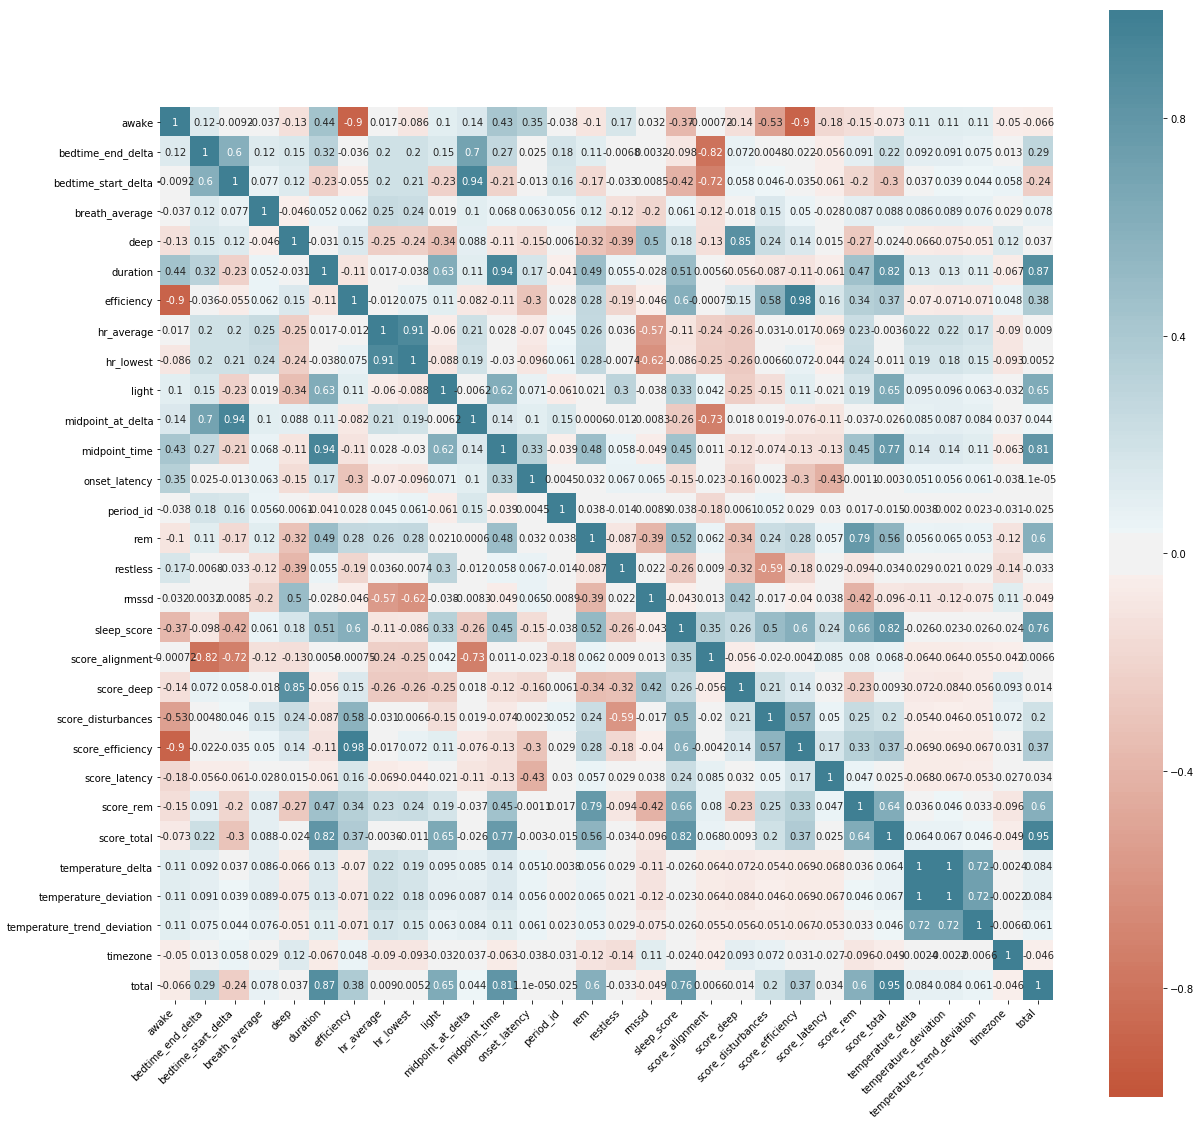

In [14]:
# defining the numeric variables:
num_types = ['awake', 'bedtime_end_delta','bedtime_start_delta','breath_average',
             'deep', 'duration', 'efficiency', 'hr_average', 'hr_lowest','light', 
             'midpoint_at_delta', 'midpoint_time', 'onset_latency', 'period_id', 'rem', 'restless',
             'rmssd', 'sleep_score', 'score_alignment', 'score_deep', 'score_disturbances', 'score_efficiency',
             'score_latency', 'score_rem', 'score_total', 'temperature_delta', 'temperature_deviation',
             'temperature_trend_deviation', 'timezone', 'total']

corr = sleep_df[num_types].corr()

plt.figure(figsize = (20,20))
ax = sns.heatmap(corr,vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True, annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

We see that some expected correlations exist, e.g. `score_alignment` and `midpoint_at_delta`, and also some that were expected to be are not present like `deep` and `score_deep`. The existing correlations will be taken into account on our modelling step, and the correlations that are lower than expected are explained by the age factor that Oura takes into account when calculating scores. See [Oura Documentation](https://cloud.ouraring.com/docs/sleep) for more details. 

Note that evaluating `sleep_score` correlations, we see that having higher score usually is associated with have more bedtime (indicated by `duration` for example). Transforming this into an actionable feature, the data suggests users should go to bed earlier (assuming they don't have such flexibility for wake-up time, especially on weekdays).

Now let's analyze the distribution of the features:

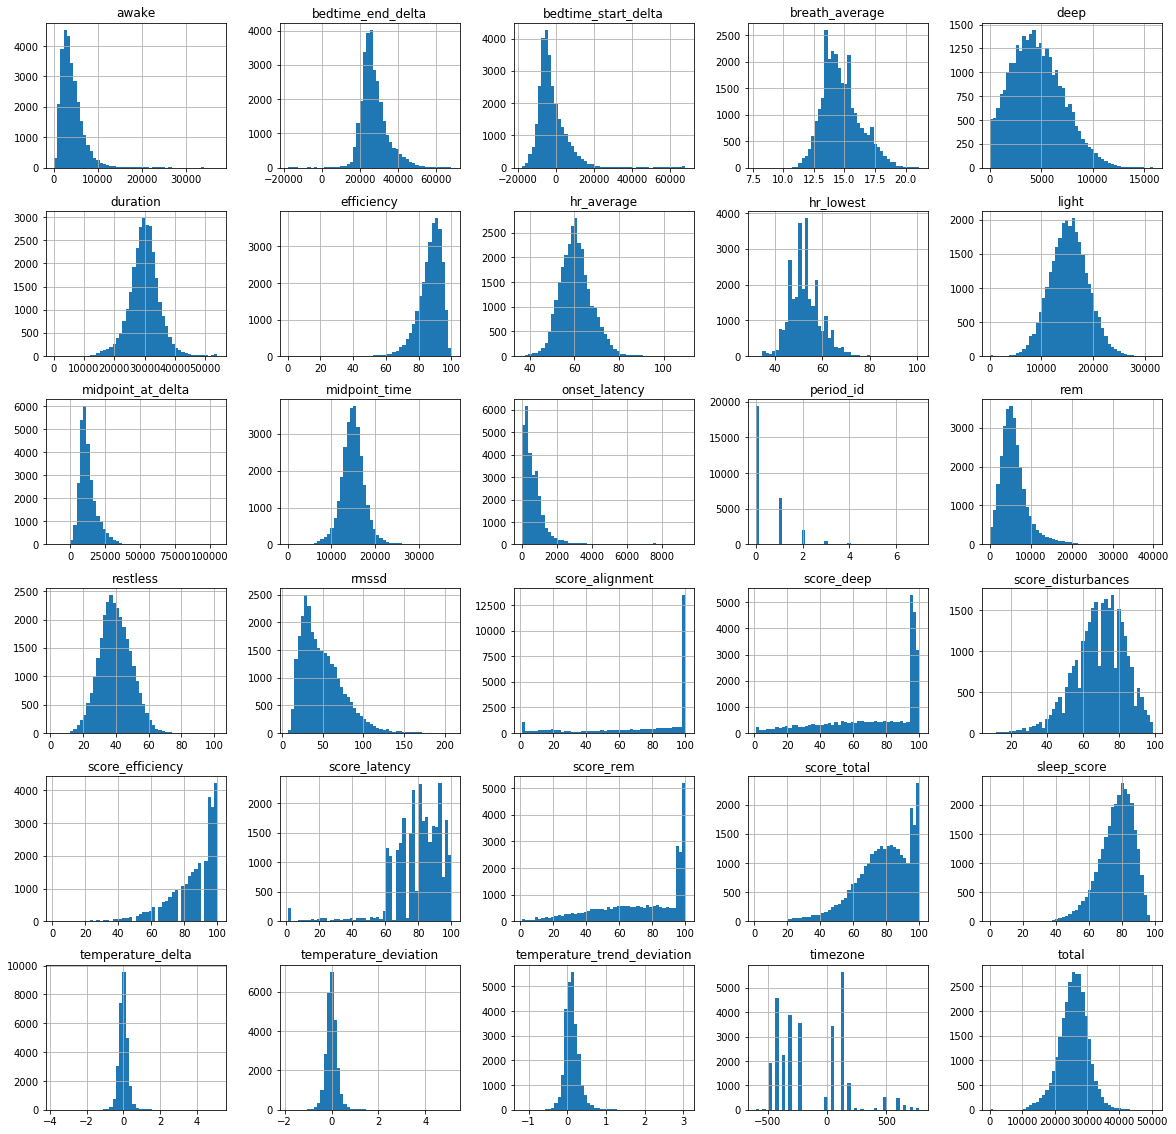

In [15]:
sleep_df[num_types].hist(figsize=(20,20), bins=50)
plt.show()

We can see that most features have pretty "normal" distributions, with exceptions like `awake`, `efficiency`, `onset_latency`, `rem`, and `mmssd`, with either positive or negative skewness, and some with long tail, like `bedtime_start_delta`. This will be considered when deciding which variables will make it to our model.

## Timezones

According to our literature review, sunlight exposure and daylight duration can influence on users sleep score. As we don't have ways to precisely compute sunlight exposure, we can try to estimate by the time the user had activites and the sunrise/sunset at his location. We considered assuming all users were at the USA, with timezones ranging from UTC-10 (or -600 minutes, in Hawaii) to UTC-4 (or -240 minutes, in Eastern Daylight Time). However, the distribution of our timezones shown that a significant part of the users are not in this timezones, therefore the assumption would be invalid.

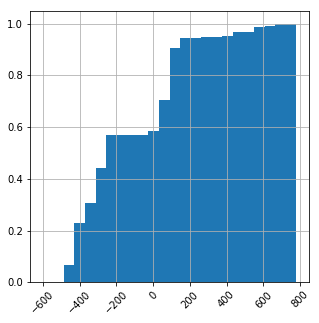

count    28600.000000
mean      -130.144406
std        282.458233
min       -600.000000
25%       -360.000000
50%       -240.000000
75%        120.000000
max        780.000000
Name: timezone, dtype: float64

In [16]:
hist = sleep_df['timezone'].hist(figsize=(5,5), bins=24, cumulative = True, density = 'Stacked')
plt.xticks(rotation=45)
plt.show()
sleep_df['timezone'].describe()

Based on the distribution above, we see that days where people were using the ring within the American timezones account for approximately 50% of our userdays, therefore we can't use this to infer sunlight exposure. Further phases of this study may rely on geo-locational data coming from the app Bioloop is rolling out for beta testers as this notebook is written.

## Is Traveling?

Traveling a lot can certainly impact sleep (maybe even justify buying a sleeping hygiene device). As mentioned, we don't have access to GPS coordinates of users, but we can approximate this feature checking how much the users shift timezones.

In [17]:
users_tz = pd.DataFrame(sleep_df.groupby(['user_id'])['timezone'].value_counts(normalize=True))
users_tz

timezone
user_id                          timezone          
35MFM6FVESRUSFVVT42XZ4EESW2QDWO6  120      0.719844
                                  60       0.280156
3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4  60       0.477454
                                  0        0.350133
                                  180      0.111406
                                 -480      0.031830
                                  300      0.015915
                                  120      0.013263
3ODDBBH2X2M657BVIKGBR3GTXOM5RNEC  240      0.645833
                                 -300      0.177083
                                 -240      0.104167
                                  120      0.072917
3RRCF34LLVBPDMZIH64OFRKQAHKRLLCO  120      0.598460
                                  60       0.356436
                                  180      0.026403
                                  240      0.009901
                                  480      0.008801
3VFEKJTF2DXVNHMXSM7MHR3NLS6LD4ES -360      0.366667
                                 -300      0.366667
                                 -600      0.133333
                                 -240      0.133333
4GNMWE24LNFB3H2A63NKHCEGYJ6SK2VM -240      0.615385
                                 -300      0.352564
                                 -480      0.016026
                                 -420      0.016026
5FMMQSD6LRZMK2I6Q7UCZD7VCHNCLBMD -420      0.568063
                                 -480      0.350785
                                 -360      0.041885
                                 -300      0.039267
5LMPI32NNEM4SZZRNZWSLWJJMBH4BRI7 -420      0.708978
...                                             ...
WVUK2CBNFCSLOMBB6XAHBDIQ5RETOHDG -360      0.600000
                                 -420      0.241379
                                 -480      0.103448
                                 -600      0.024138
                                  480      0.024138
                                 -300      0.006897
WXTBDYGYQXTTIWODVGNBNK4IIUGNTPDX -240      0.760684
                                 -300      0.230769
                                 -420      0.008547
X3KF7PN5SZMZ7R3K5EK5WNOMFYW5OYKA -300      0.507937
                                 -240      0.492063
X4B2PWSKOJKCIJC3JU7W4QW3AKNWXA7T  120      1.000000
XDPDCV254I6GMSVFCMTLP25GCVZOQGCM -240      0.833333
                                 -300      0.135965
                                 -480      0.026316
                                 -420      0.004386
XWISH4KW6U4NGIJXJ7WES5CUXQH6OXJP -240      0.736842
                                 -300      0.263158
XYVULCP6S5EMI5JU2LCELQ6NMPAXOS2A  120      0.498525
                                  60       0.483776
                                  240      0.017699
YAA6LITNNXM2LH2647SLP2JCGC5G7UI3 -420      0.847584
                                 -480      0.133829
                                  120      0.014870
                                 -360      0.003717
YXPKWLMQR3VLNCAUP4HPG2U2NMIZM52B -300      1.000000
ZCJQTLO5JAXRAI63MNUHG2GVOWG6JKMS  720      0.670000
                                  780      0.330000
ZGNWC32OXKEJBATPPJUFVMYQHU4L63SJ  120      0.564516
                                  60       0.435484

[315 rows x 1 columns]

We see that a considerable amount of users shift timezones a lot, so a boolean variable `is_traveling`  was added, where `True` means the user is out of his most frequent timezone (mode of `timezone[s]`).

## Bed time start 

In our readings, we seen that having routines on time to go to bed are beneficial to the users. In despite of finding no literature on an optimal time to go sleep, let's test it against sleep score in a simple scatter plot:

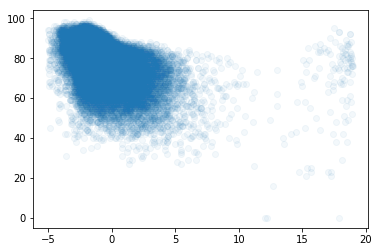

In [18]:
plt.scatter(x=sleep_df['bedtime_start_delta']/3600, y=sleep_df['sleep_score'], alpha=0.05)
plt.show()

Apparently, there may be correlation there, according to our diagram the `bedtime_start` is well correlated with age. Let's start testing that with our sampled group of users:

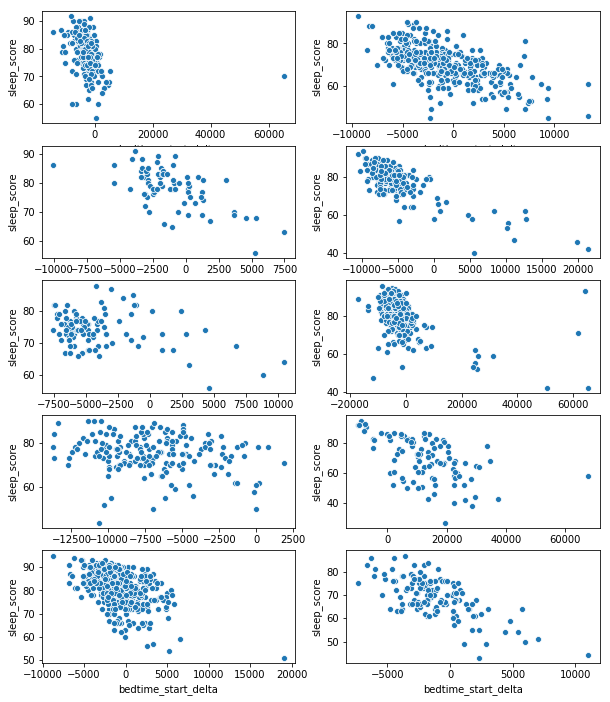

In [19]:
fig4, ax4 = plt.subplots(5,2,figsize=(10,12))

# using the same users ploted before:
for count, user in enumerate(user_array):
    r = count//2
    if (count/2).is_integer():
        c = 0
    else:
        c += 1 
    
    user_plot = sleep_df[sleep_df['user_id'] == user]
    x = user_plot['bedtime_start_delta']
    y = user_plot['sleep_score']
    
    sns.scatterplot(x = 'bedtime_start_delta', y = 'sleep_score',data = user_plot, ax=ax4[r, c])   

plt.show()

In most users we can identify a general trend: going to bed late means lower sleep score (with some users being more influenced than others). But we see that the value 0, i.e. going to bed at midnight, translates to different scores for different users. For this reason, instead of an `avg_bedtime_start` feature, we decided to use dummy variables, which indicates the deviation of going to bed for a given day in standard deviations of the avg bedtime.

Following the same idea, we will create a deviation variable for the average bedtime end delta from the previous day.

### Sleep variables: Conclusions

Finally, we see that we have features that are associated with our target `sleep_score` and even between each other. For that reason, when picking features to build our model, we decided to avoid using intermediate features that are not actionable like `rem` and `rem_score`. Instead, we will use features like `bedtime_start` and previous days `sleep_score`.

Now let's start looking at the activity dataset.

# Activity data

The activity dataset contains features that the Oura device collected during the day, from the users' physical activities. Generally, the Oura API will split activities in low, medium, and high intensities according to the "Metabolic Equivalent Minutes" (or MET) achieved during these activities (for more information on how MET is calculated, see [Oura Documentation](https://cloud.ouraring.com/docs/activity). There are also features of targets, gaps to target and notifications sent to the user. Finally, we added routine detection features such as rolling means (in a similar thought process we made for sleep features), ending up with a dataset with 73 features, some repeated from sleep data, but this was taken care of later when merging the datasets.

In [20]:
activity_df.head()

,user_Date,average_met,cal_active,cal_total,class_5min,daily_movement,day_end,day_start,high,inactive,...,rol_score_stay_active_7d,rol_beforesleep_exercise_min_7d,rol_afterwake_exercise_min_7d,rol_noon_exercise_min_7d,rol_eve_exercise_min_7d,score_training_frequency_WoW,score_training_volume_WoW,score_meet_daily_targets_WoW,score_recovery_time_WoW,activity_routine_score
0,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-23,1.53125,567,2657,0000000000000000000000000000000000000000000000...,10498,2019-04-24T03:59:59+02:00,2019-04-23T04:00:00+02:00,15,141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-24,1.50000,445,2466,1112111111111111111111111111111111111111211111...,8831,2019-04-25T03:59:59+02:00,2019-04-24T04:00:00+02:00,2,668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-25,1.43750,380,2394,1112111111111111211111122111211111111112211111...,7115,2019-04-26T03:59:59+02:00,2019-04-25T04:00:00+02:00,5,671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-26,1.59375,659,2671,1111111111111111111111111111121111111112111211...,12336,2019-04-27T03:59:59+02:00,2019-04-26T04:00:00+02:00,17,506,...,74.333333,55.0,41.666667,30.0,40.0,NaN,NaN,NaN,NaN,NaN
4,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-27,1.15625,3,1872,2222122200112211111111222222222222222122222222...,44,2019-04-28T03:59:59+02:00,2019-04-27T04:00:00+02:00,0,151,...,78.000000,55.0,41.666667,27.5,42.5,NaN,NaN,NaN,NaN,NaN


In [21]:
activity_df.columns

Index(['user_Date', 'average_met', 'cal_active', 'cal_total', 'class_5min',
       'daily_movement', 'day_end', 'day_start', 'high', 'inactive',
       'inactivity_alerts', 'low', 'medium', 'met_1min', 'met_min_high',
       'met_min_inactive', 'met_min_low', 'met_min_medium', 'non_wear', 'rest',
       'activity_score', 'score_meet_daily_targets', 'score_move_every_hour',
       'score_recovery_time', 'score_stay_active', 'score_training_frequency',
       'score_training_volume', 'steps', 'summary_date', 'target_calories',
       'target_km', 'target_miles', 'timezone', 'to_target_km',
       'to_target_miles', 'total', 'age', 'height', 'weight', 'is_male',
       'bedtime_start', 'bedtime_end', 'met_min_medium_plus', 'age_bin',
       'height_bin', 'weight_bin', 'sleep_afterMidnight',
       'afterwake_exercise_min', 'beforesleep_exercise_min',
       'noon_exercise_min', 'eve_exercise_min', 'rol_cal_total_7d',
       'rol_high_7d', 'rol_medium_7d', 'rol_steps_7d', 'rol_inactive_7d'

In [22]:
activity_df.shape

(29570, 73)

### Skewness and Collinearity

Similar to what we did with the sleep dataset, let's check the how the activities features looks like in distribution and if there are correlations.

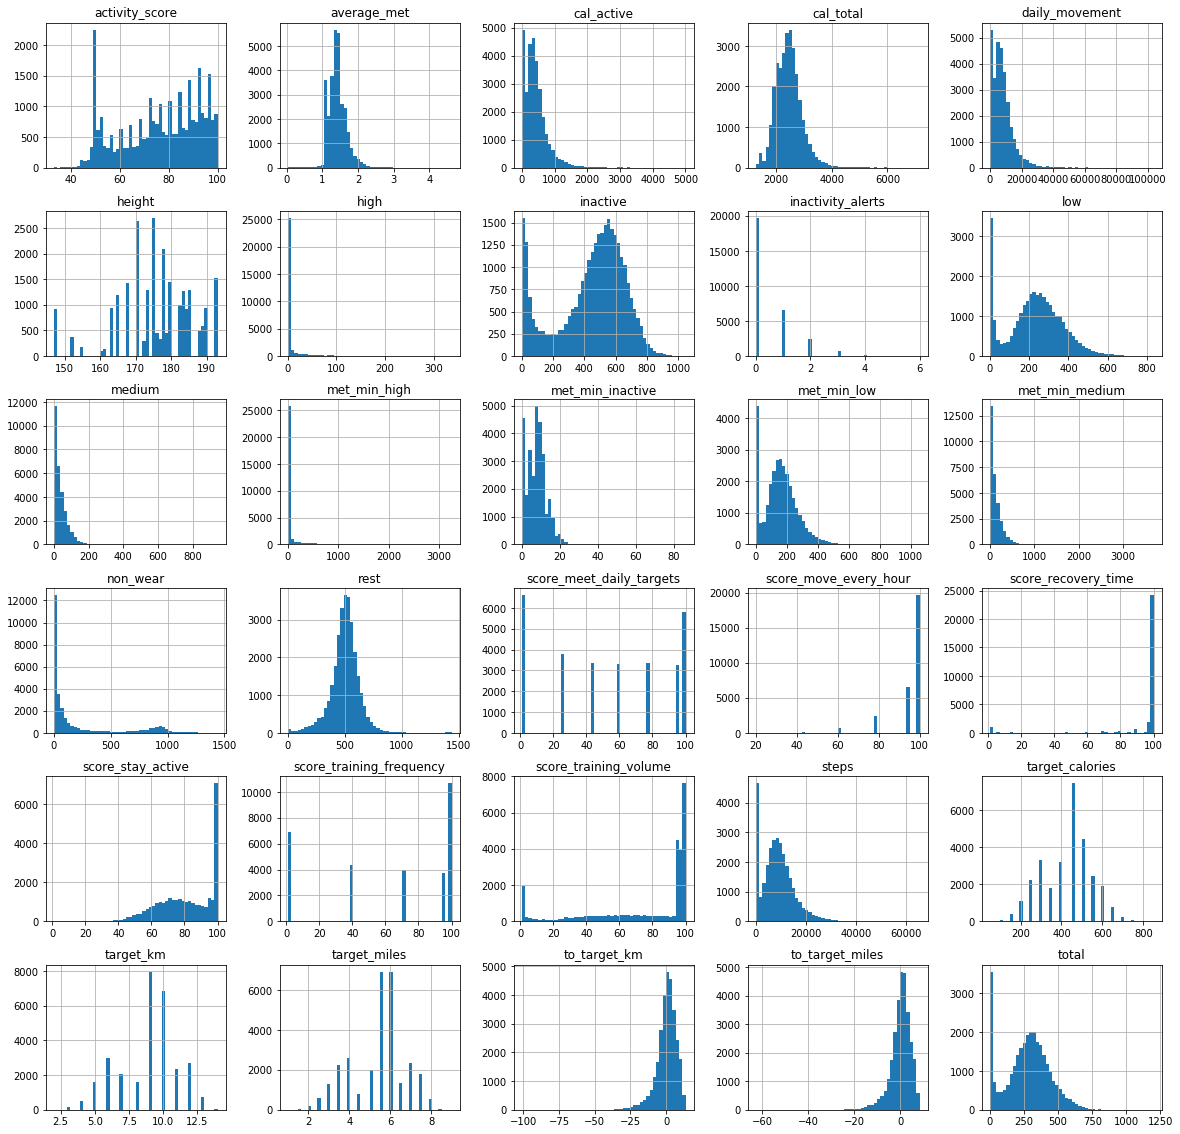

In [23]:
# filtering original numeric features only. All others are derived from theses.
num_types = ['average_met', 'cal_active', 'cal_total', 'daily_movement',
             'height', 'high', 'inactive', 'inactivity_alerts', 'low', 'medium',
             'met_min_high', 'met_min_inactive', 'met_min_low', 'met_min_medium',
             'non_wear', 'rest', 'activity_score', 'score_meet_daily_targets',
             'score_move_every_hour', 'score_recovery_time', 'score_stay_active',
             'score_training_frequency', 'score_training_volume', 'steps',
             'target_calories', 'target_km', 'target_miles', 'to_target_km',
             'to_target_miles', 'total']

activity_df[num_types].hist(figsize=(20,20), bins=50)
plt.show()

Here we seen something similar to what we've seen in sleep features: some skewed features and some "well behaved" ones. As we will derive our routine features from the latter, we will be okay in terms of unbalanced features, but let's check collinearity:

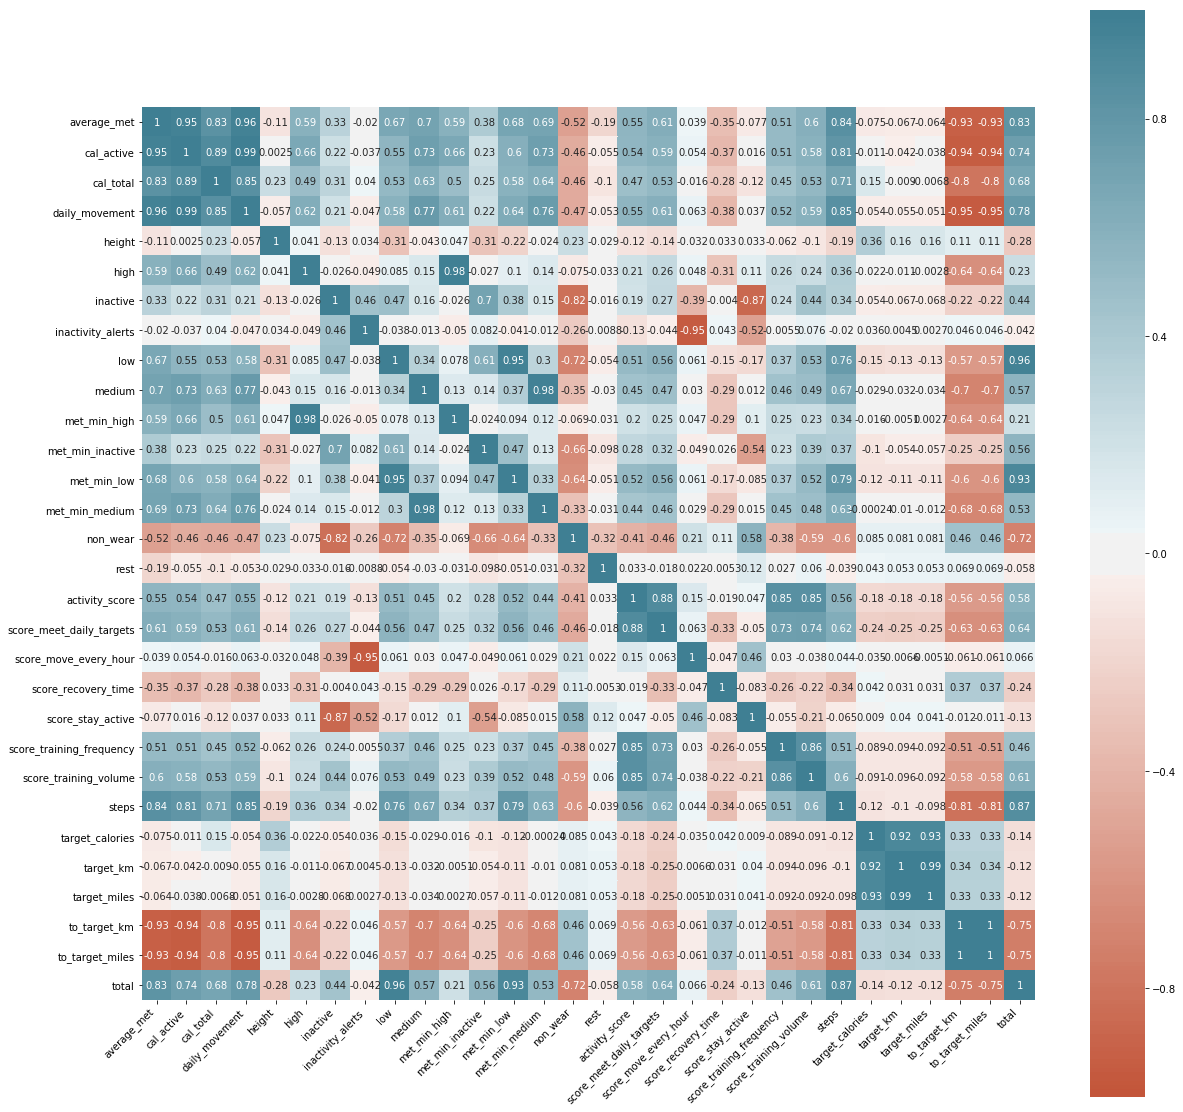

In [24]:
corr = activity_df[num_types].corr()

plt.figure(figsize = (20,20))
ax = sns.heatmap(corr,vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True, annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

As expected, the correlations here are big. We see that features that somehow evaluate the activity done during the day are highly correlated. Also, there are some obvious correlation between measured values and scores attributed to those values, like in `high` and `met_min_high`. That said, we will be careful enough to avoid adding features that are different ways of capturing the same information from the `user_date` it belongs to.

## Readiness data

The features that are derived from readiness dataset in Oura are scores that the ring API derived from the aforementioned sleep and activity data. let's take a look:

In [25]:
readiness_df.head()

,user_Date,period_id,readiness_score,score_activity_balance,score_hrv_balance,score_previous_day,score_previous_night,score_recovery_index,score_resting_hr,score_sleep_balance,score_temperature,summary_date
0,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-23,1,69,93,NaN,0,56,80,89,48,100,2019-04-23
1,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-24,0,75,76,NaN,83,51,100,96,62,100,2019-04-24
2,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-25,1,81,82,NaN,77,68,100,86,81,100,2019-04-25
3,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-26,2,63,75,NaN,66,19,1,65,66,80,2019-04-26
4,CAOTF7H2AP5N6QDF37SO4OMDOM7CTATJ|2019-04-28,0,76,87,NaN,0,92,100,34,100,79,2019-04-28


In [26]:
readiness_df.shape

(29441, 12)

In [27]:
readiness_df.columns

Index(['user_Date', 'period_id', 'readiness_score', 'score_activity_balance',
       'score_hrv_balance', 'score_previous_day', 'score_previous_night',
       'score_recovery_index', 'score_resting_hr', 'score_sleep_balance',
       'score_temperature', 'summary_date'],
      dtype='object')

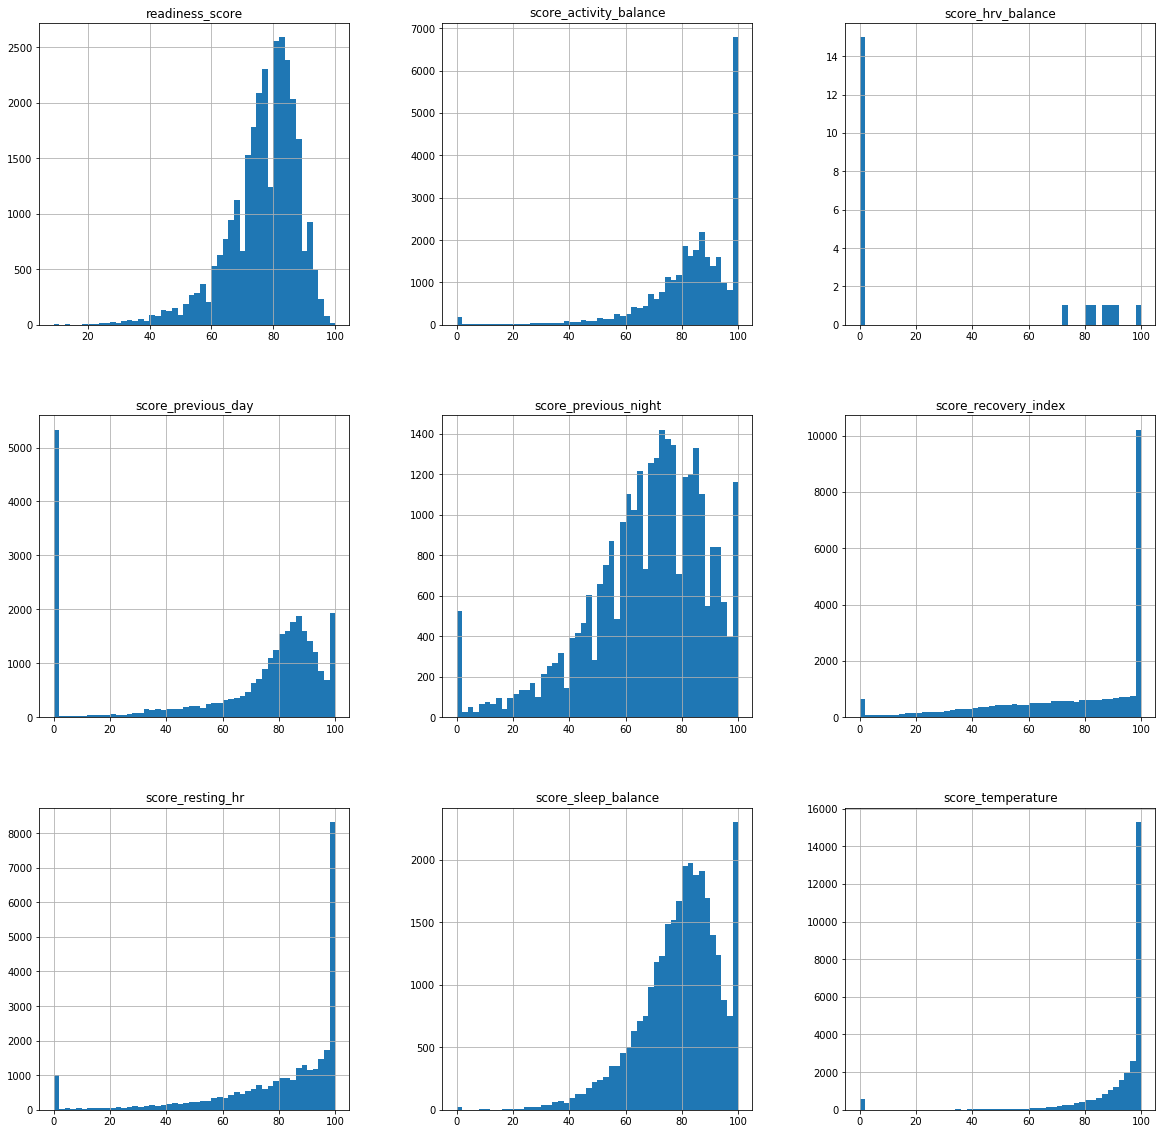

In [28]:
num_types = ['readiness_score', 'score_activity_balance',
             'score_hrv_balance', 'score_previous_day', 'score_previous_night',
             'score_recovery_index', 'score_resting_hr', 'score_sleep_balance',
             'score_temperature']

readiness_df[num_types].hist(figsize=(20,20), bins=50)
plt.show()


On the histograms above, we can see that all features are scaled scores from 0 to 100, and their intent is to build a final `readiness_score` feature that tells the user how "ready" he/she may be to go through the upcoming day. More information how this number is build can be found at the [Oura Documentation](https://cloud.ouraring.com/docs/readiness). Note this is an attempt to recommend lifestyle changes to the end user (a.k.a. our goal here). When a `readiness_score` lower than 75 is calculated for a given user, the app will show messages like "time to rest – don’t exercise today".

Here, as the readiness features are derived from sleep and activity features, we won't add any of the scores to our final dataset.

## Experiments dataset

Our last dataset contains experiments data. Each row represents one `user_date` where the user decided or was assigned to (case the experiment was randomized) either perform a treatment, or encouraged to keep his routine as regular as he/she could (to set a baseline). These experiments are suggested and tracked by [Bioloop](www.bioloopsleep.com), our partner in this research. With this data, we are not confined to the observational data we analyzed so far, and can start thinking about developing causal claims. Let's take a look at what we have available:

In [29]:
experiments_df.head()

,date,user_id,treatment_randomized,experiment_type,compliance
0,2019-04-14,JEHBSVZW5BU6KIMXO2MDJHWVY7SZO5SX,0,Magnesium - 400mg,True
1,2019-04-15,JEHBSVZW5BU6KIMXO2MDJHWVY7SZO5SX,0,Magnesium - 400mg,True
2,2019-04-16,JEHBSVZW5BU6KIMXO2MDJHWVY7SZO5SX,0,Magnesium - 400mg,NaN
3,2019-04-17,JEHBSVZW5BU6KIMXO2MDJHWVY7SZO5SX,0,Magnesium - 400mg,True
4,2019-04-18,JEHBSVZW5BU6KIMXO2MDJHWVY7SZO5SX,0,Magnesium - 400mg,NaN


Here `compliance` is `True` when a user logged-in with Bioloop platform and actively said he/she did as recommended by the experiment schedule. On the other side `False` means that the user actively reported being unable to follow the schedule, and `NaN` means the user did not checked-in on that `user_date` at alle. Also important to note that only experiments that were finished were extracted from the original Bioloop dataset.

In [30]:
experiments_df['experiment_type'].unique()

array(['Magnesium - 400mg ', 'No electronics before bed - 11pm ',
       'Magnesium ', 'Pink noise ', 'Meditate - 10 minutes ',
       'Meditation ', 'Reishi mushroom ', 'Meditate - Custom',
       'Blue blocking glasses before bed ', 'Earplugs ',
       '16:8 Intermittent Fasting ', 'Coffee amount & timing on sleep ',
       'Meditate - 5 minutes ', 'Early time-restricted feeding ',
       'No electronics before bed ', 'Cooling pad at bedtime ',
       'Chamomile tea ', 'Melatonin '], dtype=object)

In [31]:
experiments_df.shape

(762, 5)

In [32]:
experiments_df['compliance'].describe()

count      688
unique       2
top       True
freq       611
Name: compliance, dtype: object

Note that only 74 `user_date` have compliance equal `NaN`, i.e. in 90% of the times the users took their time to log-in the Bioloop platform and report their experiment data. This is an impressive number (even more impressive when remembered that up to the publication of this notebook, the first version of the Bioloop apps for IOS and Android mobile systems were in beta version, which means that probably none of this check-in data comes from them). From the valid `user_dates` we have seen that 611 out of 688 (or 89%) were compliant. These numbers corroborate the assumptions that users from Bioloop platform with Oura devices are highly dedicated on improving their sleep score and strengthens our similarity assumption between users.

Finally, we need to emphasize that all "treatments" studied here have no potential to harm user's health, being either recommendations on lifestyle (like reducing coffee, feeding schedule or using digital generated noises while sleeping) or taking substances that can be found on any pharmacy without prescription (like melatonin, magnesium and chamomile).

## Gold Dataset

Finally, we merged all the previous findings in one dataset that contains all relevant features discussed on the sections of this notebook for each `user_date`. One important note to make here is that we added each `user_id` as a one-hot-encoded feature, as a possibility to use that information as an input on one of our models and capture user intricacies. As of now, we have 100 different active users, which gives us 175 features derived from user actions during the days.

In [33]:
df.shape

(28960, 275)

In [34]:
df.sample(20)

,avg_sleep_score_next_week,awake,awake_norm,bedtime_end,bedtime_end_delta,bedtime_end_dev+1,bedtime_end_dev+2,bedtime_end_dev+3,bedtime_end_dev-1,bedtime_end_dev-2,...,user_id_X3KF7PN5SZMZ7R3K5EK5WNOMFYW5OYKA,user_id_X4B2PWSKOJKCIJC3JU7W4QW3AKNWXA7T,user_id_XDPDCV254I6GMSVFCMTLP25GCVZOQGCM,user_id_XWISH4KW6U4NGIJXJ7WES5CUXQH6OXJP,user_id_XYVULCP6S5EMI5JU2LCELQ6NMPAXOS2A,user_id_YAA6LITNNXM2LH2647SLP2JCGC5G7UI3,user_id_YXPKWLMQR3VLNCAUP4HPG2U2NMIZM52B,user_id_ZCJQTLO5JAXRAI63MNUHG2GVOWG6JKMS,user_id_ZGNWC32OXKEJBATPPJUFVMYQHU4L63SJ,avg_sleep_score_next_week_binarized
user_date,,,,,,,,,,,,,,,,,,,,,
JCZWBWNSAIMC4AURKPGNI5MU42C7JK3Y|2019-09-29,NaN,3480.0,0.128319,2019-09-30T05:00:54+10:00,18054.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
BSMMIBAIXMNSKRWKZLSHXA7VCBFFYQGK|2018-06-09,82.142857,3240.0,0.109091,2018-06-10T07:00:43+02:00,25243.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
AL5K2E56QSVWCQFQGSGRELQPVTKOAVRJ|2019-06-15,80.428571,3840.0,0.131687,2019-06-16T07:04:21-05:00,25461.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
RYREDK2UBSQ5UJBUOFSCLUNKFUHFVNNT|2019-06-03,77.285714,2520.0,0.079848,2019-06-04T08:00:05-04:00,28805.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
XYVULCP6S5EMI5JU2LCELQ6NMPAXOS2A|2019-02-04,41.000000,6810.0,0.627072,2019-02-05T16:33:28+01:00,59608.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
SVOVVGTMXMFCRMGNE6N4PCV6EA7GOUM7|2019-03-05,85.285714,4470.0,0.141098,2019-03-06T07:23:40-08:00,26620.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
WXTBDYGYQXTTIWODVGNBNK4IIUGNTPDX|2019-10-09,75.857143,3360.0,0.107486,2019-10-10T07:57:43-04:00,28663.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
G4S6FQ4FGBFPZ3PAXUG2ANQWGIU4KVGF|2019-08-09,75.428571,4380.0,0.132246,2019-08-10T06:26:58+03:00,23218.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
UEBVTTCGFDZ6U3ATPSOR4ZABFJ6RGKNA|2019-02-07,75.571429,7920.0,0.242647,2019-02-08T08:32:20+01:00,30740.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Conclusion

As seen above as a random sample, our main dataframe contains categorical, numeric, Boolean and one-hot-encoded features which, in the end of the day, represent a rich and user generated dataset that will be used by this team to investigate how habits influence sleep quality and what can be done to improve it, either by changing one's routine or adding suplements and/or introducing new and healthier habits.

This is the end of the data exploration in our quest for improve sleep quality, but you can go further and see how this data was extracted, transformed and loaded into this dataset, and how our proposed models performed on predicting sleep score. For conciseness, we kept the ETL and the modeling notebooks together, but you can see models that used plain SKLearn modules [here](https://github.com/ShirazChakraverty/zeez_mvp/blob/master/ETL%20and%20Model%20w%20sklearn.ipynb) and the ones where we used automated models and optimal hyper-parameter search using H2O [here](https://github.com/ShirazChakraverty/zeez_mvp/blob/master/ETL_and_Model_H2O_shippable_version.ipynb). Finally, take a look on the code that build our recommendation system [here](https://github.com/ShirazChakraverty/zeez_mvp/blob/master/Recommender.ipynb) and how this will look after incorporated in Bioloop platform [here](www.bioloopsleep.com/demo). For a complete story of this study, please see the blog post available on the header of this page and get in touch with the authors mentioned in our main [webpage](http://people.ischool.berkeley.edu/~marcelo.queiroz/Zeez/index.html).